# EDSA 2021: Sendy Logistics Challenge
Predict the estimated time of arrival (ETA) for motorbike deliveries in Nairobi

# Overview

### - Introduction
### - Importing libraries and data
### - Exploratory Data Analysis
### - Data Cleaning and Formatting
### - Feature Engineering
### - Train/Test Split
### - Modeling
### - Making Predictions
### - Submission

# Introduction

In this notebook, based on historic data used to predict an accurate time for the arrival of the rider at the destination of a package, we will be building a machine learning model that predicts an accurate delivery time, from picking up a package to arriving at the final destination. An accurate arrival time prediction will help all businesses to improve their logistics and communicate an accurate time to their customers.

# Importing Python libraries

In [1]:
!pip install lightgbm

In [2]:
!pip install xgboost

In [3]:
#Linear algebra
import numpy as np

#Data processing
import pandas as pd

#Date library
import datetime as dt

#Data visualization
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#Metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

#Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

#import xgboost as xgb
import lightgbm as lgbm

sns.set(style='white', context='notebook', palette='deep')

# Importing the dataset

In [6]:
#Train_Masked has extra columns: Delivery destination (day, month, time)

train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
rider_df = pd.read_csv("Riders.csv")
variable_df = pd.read_csv('VariableDefinitions.csv')

print(train_df.shape, test_df.shape, rider_df.shape, variable_df.shape)

(21201, 29) (7068, 25) (960, 5) (35, 2)


# Exploritory Data Analysis

## Understanding the train and test datasets

In [7]:
train_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Arrival at Destination - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id,Time from Pickup to Arrival
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,10:39:55 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,745
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,12:17:22 PM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,1993
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,1:00:38 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,455
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,10:05:27 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,1341
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,10:25:37 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,1214


In [8]:
test_df.head()

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_19248,User_Id_3355,Bike,3,Business,27,3,4:44:10 PM,27,3,...,3,5:06:47 PM,8,NaN,NaN,-1.333275,36.870815,-1.305249,36.822390,Rider_Id_192
1,Order_No_12736,User_Id_3647,Bike,3,Business,17,5,12:57:35 PM,17,5,...,5,1:25:37 PM,5,NaN,NaN,-1.272639,36.794723,-1.277007,36.823907,Rider_Id_868
2,Order_No_768,User_Id_2154,Bike,3,Business,27,4,11:08:14 AM,27,4,...,4,11:57:54 AM,5,22.8,NaN,-1.290894,36.822971,-1.276574,36.851365,Rider_Id_26
3,Order_No_15332,User_Id_2910,Bike,3,Business,17,1,1:51:35 PM,17,1,...,1,2:16:52 PM,5,24.5,NaN,-1.290503,36.809646,-1.303382,36.790658,Rider_Id_685
4,Order_No_21373,User_Id_1205,Bike,3,Business,11,2,11:30:28 AM,11,2,...,2,11:56:04 AM,6,24.4,NaN,-1.281081,36.814423,-1.266467,36.792161,Rider_Id_858


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21201 entries, 0 to 21200
Data columns (total 29 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Order No                                   21201 non-null  object 
 1   User Id                                    21201 non-null  object 
 2   Vehicle Type                               21201 non-null  object 
 3   Platform Type                              21201 non-null  int64  
 4   Personal or Business                       21201 non-null  object 
 5   Placement - Day of Month                   21201 non-null  int64  
 6   Placement - Weekday (Mo = 1)               21201 non-null  int64  
 7   Placement - Time                           21201 non-null  object 
 8   Confirmation - Day of Month                21201 non-null  int64  
 9   Confirmation - Weekday (Mo = 1)            21201 non-null  int64  
 10  Confirmation - Time   

In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7068 entries, 0 to 7067
Data columns (total 25 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Order No                              7068 non-null   object 
 1   User Id                               7068 non-null   object 
 2   Vehicle Type                          7068 non-null   object 
 3   Platform Type                         7068 non-null   int64  
 4   Personal or Business                  7068 non-null   object 
 5   Placement - Day of Month              7068 non-null   int64  
 6   Placement - Weekday (Mo = 1)          7068 non-null   int64  
 7   Placement - Time                      7068 non-null   object 
 8   Confirmation - Day of Month           7068 non-null   int64  
 9   Confirmation - Weekday (Mo = 1)       7068 non-null   int64  
 10  Confirmation - Time                   7068 non-null   object 
 11  Arrival at Pickup

In [11]:
train_df.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Arrival at Destination - Day of Month,Arrival at Destination - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Time from Pickup to Arrival
count,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000,16835.000000,552.000000,21201.000000,21201.000000,21201.000000,21201.000000,21201.000000
mean,2.752182,15.653696,3.240083,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,15.653837,3.240225,9.506533,23.258889,7.905797,-1.281470,36.811264,-1.282581,36.811220,1556.920947
std,0.625178,8.798916,1.567295,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,8.798886,1.567228,5.668963,3.615768,17.089971,0.030507,0.037473,0.034824,0.044721,987.270788
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.200000,0.100000,-1.438302,36.653621,-1.430298,36.606594,1.000000
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.075000,-1.300921,36.784605,-1.301201,36.785661,882.000000
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.500000,2.900000,-1.279395,36.807040,-1.284382,36.808002,1369.000000
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,26.000000,4.900000,-1.257147,36.829741,-1.261177,36.829477,2040.000000
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,49.000000,32.100000,99.100000,-1.147170,36.991046,-1.030225,37.016779,7883.000000


In [12]:
test_df.describe()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
count,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,7068.000000,5631.000000,199.000000,7068.000000,7068.000000,7068.000000,7068.000000
mean,2.752122,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,15.621817,3.249859,9.458970,23.246120,6.651759,-1.282043,36.811148,-1.282255,36.811326
std,0.624000,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,8.776650,1.580926,5.575689,3.591161,14.085439,0.030044,0.037962,0.034236,0.043507
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13.200000,0.100000,-1.433512,36.653828,-1.422652,36.639195
25%,3.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,8.000000,2.000000,5.000000,20.600000,1.100000,-1.301201,36.784605,-1.300921,36.786546
50%,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,15.000000,3.000000,8.000000,23.400000,2.900000,-1.281301,36.807219,-1.283219,36.807927
75%,3.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,23.000000,5.000000,13.000000,25.900000,4.950000,-1.257274,36.829716,-1.261256,36.828195
max,4.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,31.000000,7.000000,47.000000,32.100000,99.100000,-1.148352,36.991046,-1.030225,37.018958


### Check which cols are in train and not in test data

In [14]:
for col in train_df.columns:
    if col not in test_df.columns:
        print(col)

Arrival at Destination - Day of Month
Arrival at Destination - Weekday (Mo = 1)
Arrival at Destination - Time
Time from Pickup to Arrival


### Match the number of train columns to the number of test columns and also separate the target variable

In [15]:
# save the columns from the test dataframe into a new list called testcols
testcols = test_df.columns

# reassign the number of the train dataframe to match that of the test by saving them to an updated dataframe, newtrain
train1 = train_df[testcols]

# Seperate the target variable from the predictor variable
y = np.array(train_df['Time from Pickup to Arrival']).reshape(-1, 1)

In [16]:
#Drop data not available in test, Pickup Time + label = Arrival times

train_df = train_df.drop(['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)', 'Arrival at Destination - Time'], axis=1)

In [18]:
# print the new columns of the train and test data to show that they are the same
print(train1.columns)
print(test_df.columns)

Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at Pickup - Weekday (Mo = 1)', 'Arrival at Pickup - Time',
       'Pickup - Day of Month', 'Pickup - Weekday (Mo = 1)', 'Pickup - Time',
       'Distance (KM)', 'Temperature', 'Precipitation in millimeters',
       'Pickup Lat', 'Pickup Long', 'Destination Lat', 'Destination Long',
       'Rider Id'],
      dtype='object')
Index(['Order No', 'User Id', 'Vehicle Type', 'Platform Type',
       'Personal or Business', 'Placement - Day of Month',
       'Placement - Weekday (Mo = 1)', 'Placement - Time',
       'Confirmation - Day of Month', 'Confirmation - Weekday (Mo = 1)',
       'Confirmation - Time', 'Arrival at Pickup - Day of Month',
       'Arrival at 

## Missing values

<AxesSubplot:>

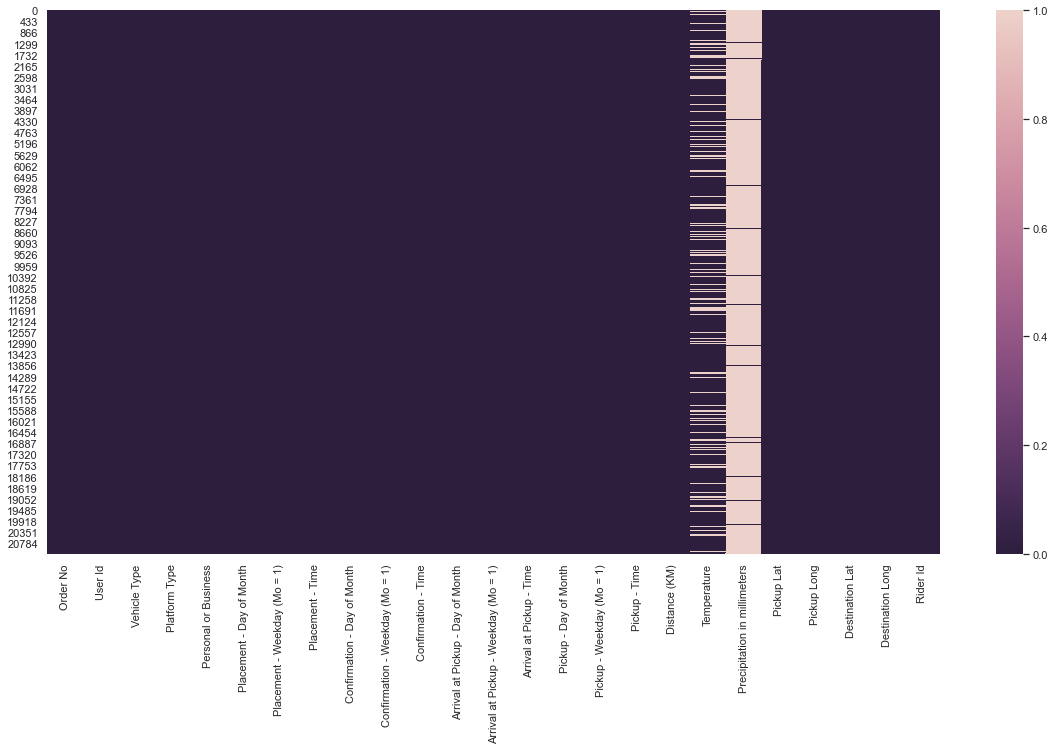

In [19]:
#plot cmap
plt.figure(figsize=(20, 10))
cmap = sns.cubehelix_palette(as_cmap=True, reverse=True)
sns.heatmap(train1.isnull(), cmap=cmap)


In [20]:
train1.isnull().sum()

Order No                                    0
User Id                                     0
Vehicle Type                                0
Platform Type                               0
Personal or Business                        0
Placement - Day of Month                    0
Placement - Weekday (Mo = 1)                0
Placement - Time                            0
Confirmation - Day of Month                 0
Confirmation - Weekday (Mo = 1)             0
Confirmation - Time                         0
Arrival at Pickup - Day of Month            0
Arrival at Pickup - Weekday (Mo = 1)        0
Arrival at Pickup - Time                    0
Pickup - Day of Month                       0
Pickup - Weekday (Mo = 1)                   0
Pickup - Time                               0
Distance (KM)                               0
Temperature                              4366
Precipitation in millimeters            20649
Pickup Lat                                  0
Pickup Long                       

In [21]:
test_df.isnull().sum()

Order No                                   0
User Id                                    0
Vehicle Type                               0
Platform Type                              0
Personal or Business                       0
Placement - Day of Month                   0
Placement - Weekday (Mo = 1)               0
Placement - Time                           0
Confirmation - Day of Month                0
Confirmation - Weekday (Mo = 1)            0
Confirmation - Time                        0
Arrival at Pickup - Day of Month           0
Arrival at Pickup - Weekday (Mo = 1)       0
Arrival at Pickup - Time                   0
Pickup - Day of Month                      0
Pickup - Weekday (Mo = 1)                  0
Pickup - Time                              0
Distance (KM)                              0
Temperature                             1437
Precipitation in millimeters            6869
Pickup Lat                                 0
Pickup Long                                0
Destinatio

In [22]:
#Percentage of the missing values
def missing_values(df, threshold=0):
    """Returns the feature name and the % of  missing values as dataframe"""

    return pd.DataFrame(data= {col: (df[col].isnull().mean()) for col in df.columns if df[col].isnull().mean() > threshold}, 
             index=['% of Missing values']
             ).T

In [23]:
missing_values(train1)

,% of Missing values
Temperature,0.205934
Precipitation in millimeters,0.973963


In [25]:
missing_values(test_df)

,% of Missing values
Temperature,0.203311
Precipitation in millimeters,0.971845


## Distribution

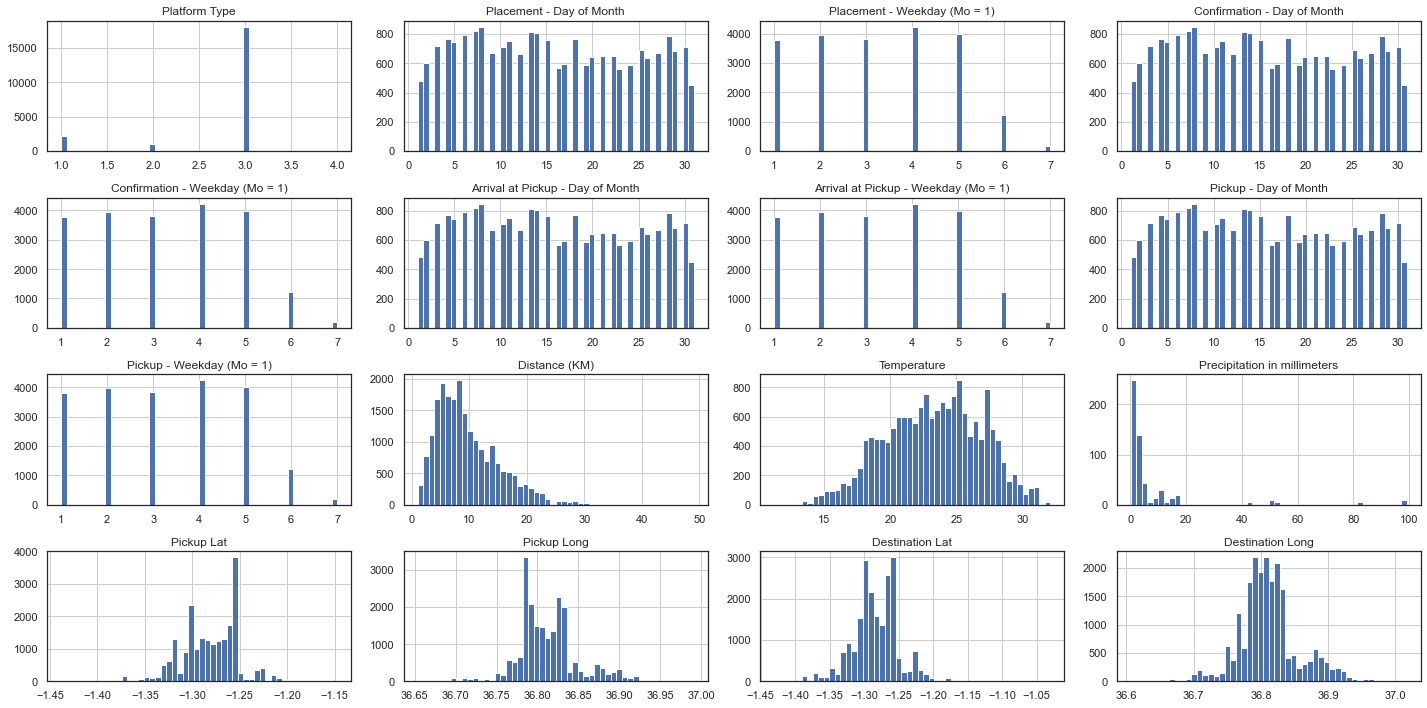

In [26]:
#Distribution review for train data
train1[[col for col in train1.select_dtypes(include='number')]].hist(bins=50, figsize=(20,10))
plt.tight_layout()
plt.show()

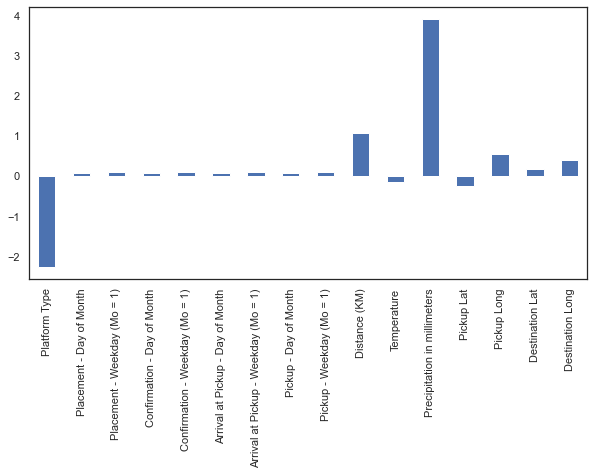

In [27]:
#Column Skewness of the testing dataset
train1.skew().plot.bar(figsize =(10,5))
plt.show()

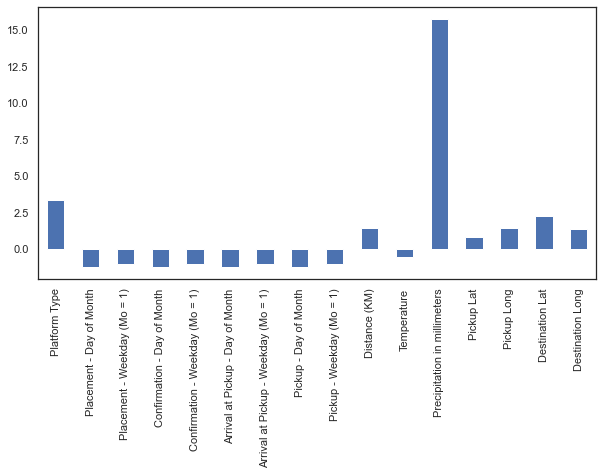

In [28]:
## Univariate Anaysis
# Calculating Skewness in the columns of our Training dataset
train1.kurt().plot.bar(figsize =(10,5))
plt.show()

In [29]:
CorrMatrix_train = train1.corr()
CorrMatrix_train.head(5)

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
Platform Type,1.000000,0.012764,-0.058038,0.012770,-0.058005,0.012770,-0.058005,0.012770,-0.058005,0.005528,0.225060,-0.055948,-0.002742,0.021327,0.006319,0.043924
Placement - Day of Month,0.012764,1.000000,0.026148,0.999998,0.026122,0.999998,0.026122,0.999998,0.026122,-0.007585,0.013097,-0.204143,-0.004929,-0.005453,0.007541,0.002077
Placement - Weekday (Mo = 1),-0.058038,0.026148,1.000000,0.026132,0.999952,0.026132,0.999952,0.026132,0.999952,0.003582,0.031064,-0.050592,-0.000918,0.011008,-0.004299,-0.000875
Confirmation - Day of Month,0.012770,0.999998,0.026132,1.000000,0.026123,1.000000,0.026123,1.000000,0.026123,-0.007587,0.013099,-0.204143,-0.004923,-0.005448,0.007550,0.002073
Confirmation - Weekday (Mo = 1),-0.058005,0.026122,0.999952,0.026123,1.000000,0.026123,1.000000,0.026123,1.000000,0.003574,0.031074,-0.050592,-0.000883,0.011036,-0.004251,-0.000900


Text(0.5, 1.05, 'Pearson Correlation of Features')

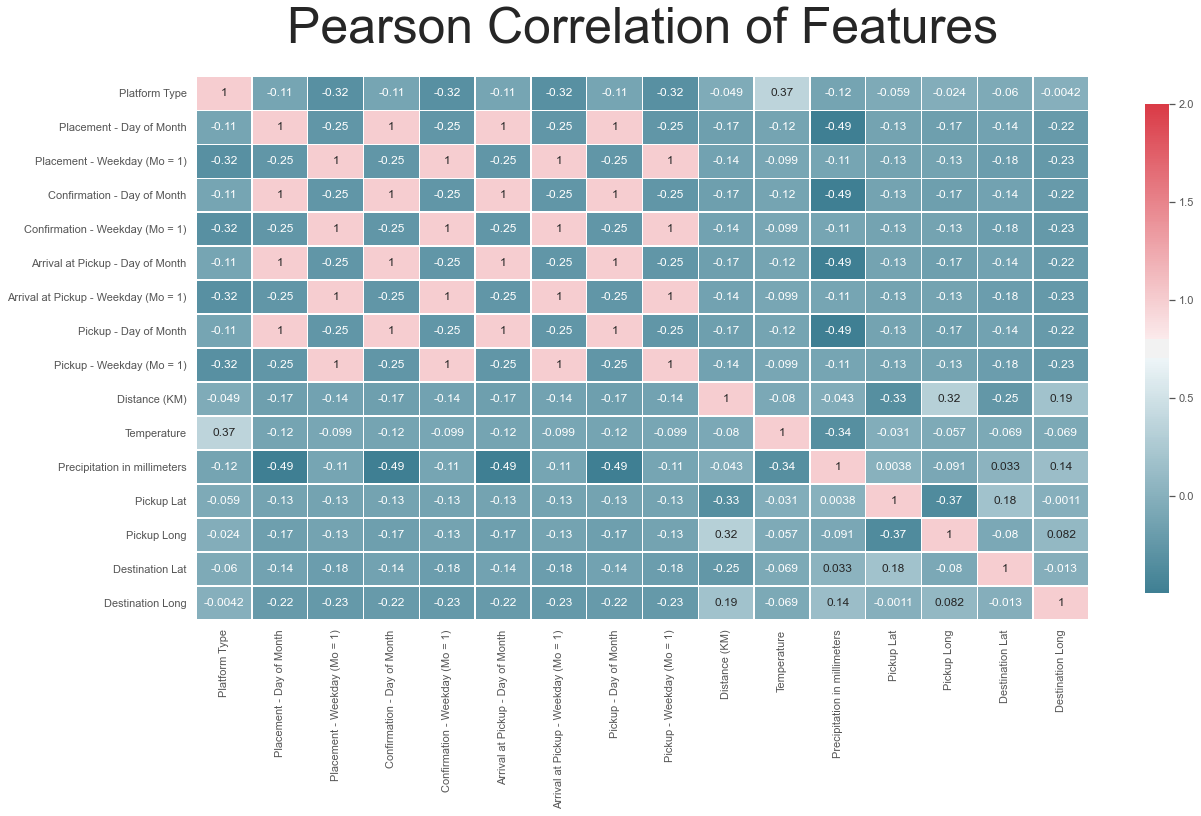

In [31]:
style.use('ggplot')
cm = CorrMatrix_train.corr()
colormap = sns.diverging_palette(220, 10, as_cmap = True)
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, cmap = colormap,cbar_kws={'shrink':.9 },
           linewidths=0.5,vmax=2.0, linecolor='white',annot_kws={'fontsize':12 })
plt.title('Pearson Correlation of Features', y=1.05, size=50)

### Personal or Business

<AxesSubplot:>

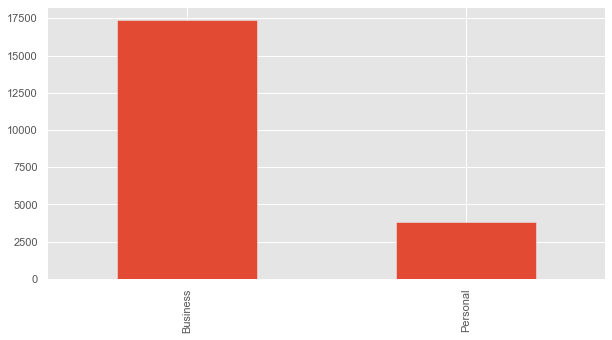

In [32]:
train1['Personal or Business'].value_counts().plot(kind= 'bar' , figsize = [10,5])

### Platform type

<AxesSubplot:>

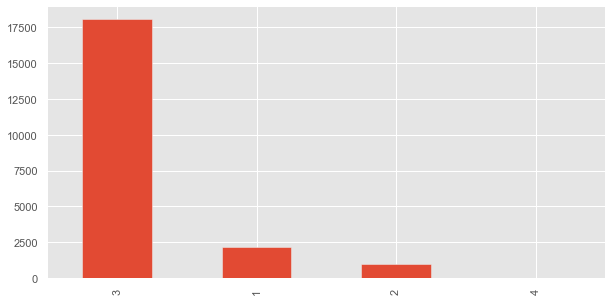

In [33]:
train1['Platform Type'].value_counts().plot(kind= 'bar' , figsize = [10,5])

### Vehicle Type

<AxesSubplot:>

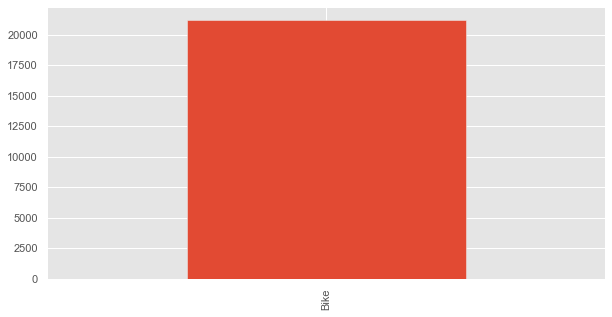

In [34]:
train1['Vehicle Type'].value_counts().plot(kind= 'bar' , figsize = [10,5])

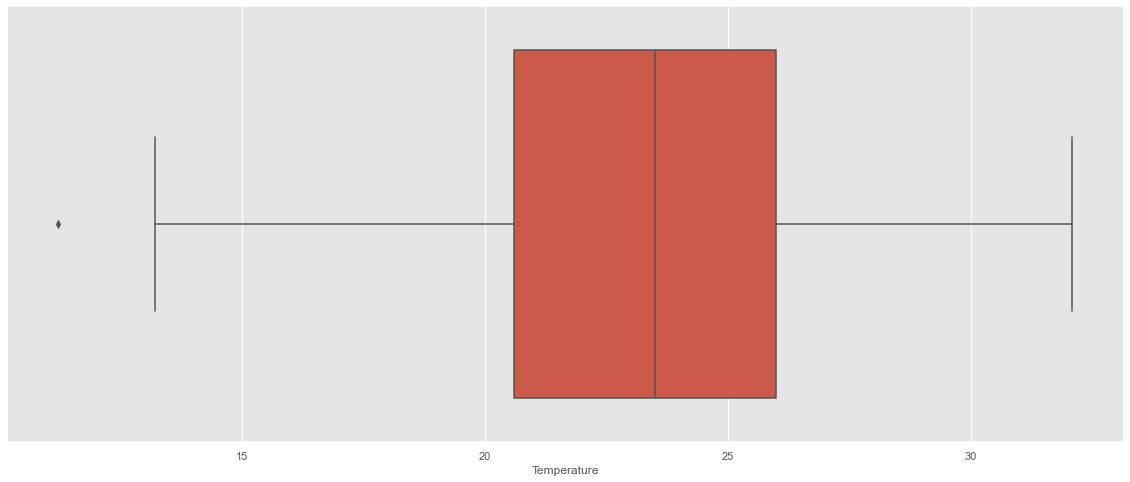

In [35]:
#Outliers Overview for numeric features
plt.figure(figsize=(20, 8))
sns.boxplot(train1['Temperature'])
plt.show()

In [36]:
Numeric_Training = train1._get_numeric_data()
Numeric_Training.head()

,Platform Type,Placement - Day of Month,Placement - Weekday (Mo = 1),Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),Arrival at Pickup - Day of Month,Arrival at Pickup - Weekday (Mo = 1),Pickup - Day of Month,Pickup - Weekday (Mo = 1),Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long
0,3,9,5,9,5,9,5,9,5,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741
1,3,12,5,12,5,12,5,12,5,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358
2,3,30,2,30,2,30,2,30,2,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195
3,3,15,5,15,5,15,5,15,5,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063
4,1,13,1,13,1,13,1,13,1,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817


In [37]:
train1['Time from Pickup to Arrival'].value_counts().plot(kind= 'bar' , figsize = [10,5]) #returns error

KeyError: 'Time from Pickup to Arrival'

In [38]:
l = train1.values  #returns error
number_of_columns= 12
number_of_rows = len(l)-1/number_of_columns
plt.figure(figsize=(number_of_columns,5*number_of_rows))
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.set_style('whitegrid')
    sns.boxplot(df[l[i]],color='green',orient='v')
    plt.tight_layout()

NameError: name 'df' is not defined

ValueError: Image size of 864x7632330 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x7.63233e+06 with 1 Axes>

In [39]:
plt.figure(figsize=(number_of_columns_Test,8*number_of_rows_Test)) #returns error
for i in range(0,len(nu_tra)):
    plt.subplot(number_of_rows_Test + 1,number_of_columns_Test,i+1)
    chart=sns.distplot(train1[nu_tra[i]],kde=True) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=-180, 
                          horizontalalignment='right')
plt.show()

NameError: name 'number_of_columns_Test' is not defined

### Target

In [80]:
#Useful statistics about our target column

train1['Time from Pickup to Arrival'].describe() #returns error

KeyError: 'Time from Pickup to Arrival'

In [41]:
train1

,Order No,User Id,Vehicle Type,Platform Type,Personal or Business,Placement - Day of Month,Placement - Weekday (Mo = 1),Placement - Time,Confirmation - Day of Month,Confirmation - Weekday (Mo = 1),...,Pickup - Weekday (Mo = 1),Pickup - Time,Distance (KM),Temperature,Precipitation in millimeters,Pickup Lat,Pickup Long,Destination Lat,Destination Long,Rider Id
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,9:35:46 AM,9,5,...,5,10:27:30 AM,4,20.4,NaN,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16 AM,12,5,...,5,11:44:09 AM,16,26.4,NaN,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25 PM,30,2,...,2,12:53:03 PM,3,NaN,NaN,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,9:25:34 AM,15,5,...,5,9:43:06 AM,9,19.2,NaN,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,9:55:18 AM,13,1,...,1,10:05:23 AM,9,15.4,NaN,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21196,Order_No_8834,User_Id_2001,Bike,3,Personal,20,3,3:54:38 PM,20,3,...,3,4:20:08 PM,3,28.6,NaN,-1.258414,36.804800,-1.275285,36.802702,Rider_Id_953
21197,Order_No_22892,User_Id_1796,Bike,3,Business,13,6,10:13:34 AM,13,6,...,6,10:33:27 AM,7,26.0,NaN,-1.307143,36.825009,-1.331619,36.847976,Rider_Id_155
21198,Order_No_2831,User_Id_2956,Bike,3,Business,7,4,5:06:16 PM,7,4,...,4,5:50:52 PM,20,29.2,NaN,-1.286018,36.897534,-1.258414,36.804800,Rider_Id_697
21199,Order_No_6174,User_Id_2524,Bike,1,Personal,4,3,9:31:39 AM,4,3,...,3,9:45:15 AM,13,15.0,NaN,-1.250030,36.874167,-1.279209,36.794872,Rider_Id_347


In [42]:
(train1['Time from Pickup to Arrival']/60).hist(bins=50) #returns error
plt.title("Delivery time distribution") 
plt.xlabel("Delivery time (minutes)")
plt.ylabel("Frequency")
plt.show()

KeyError: 'Time from Pickup to Arrival'

In [43]:
#Outliers Overview for numeric features
plt.figure(figsize=(20, 8))
sns.boxplot(x="variable", y="value", data=pd.melt(test_df)) #returns error
plt.show()

ValueError: Neither the `x` nor `y` variable appears to be numeric.

<Figure size 1440x576 with 0 Axes>

In [44]:
plt.figure(figsize=(2*number_of_columns,5*number_of_rows)) #returns error
for i in range(0,len(l)):
    plt.subplot(number_of_rows + 1,number_of_columns,i+1)
    sns.distplot(df[l[i]],kde=True)

NameError: name 'df' is not defined

ValueError: Image size of 1728x7632330 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1728x7.63233e+06 with 1 Axes>

# Data Cleaning and Formatting

## Creating Full_df

In [45]:
#Create (full_df = train + test) ** caution (dont shuffle, avoid drop/adding rows)
#explore training, make (column) changes to full, later we use the border to separate
#Be careful of information leakage

border = train1.shape[0]
test_df['Time from Pickup to Arrival'] = [np.nan]* test_df.shape[0]
full_df = pd.concat([train1, test_df], axis=0, ignore_index=True)

train1.shape, test_df.shape, full_df.shape

((21201, 25), (7068, 26), (28269, 26))

### Renaming columns

In [46]:
#Renaming columns (shorten, remove space, standardize)
new_names = {"Order No": "Order_No", "User Id": "User_Id", "Vehicle Type": "Vehicle_Type",
    "Personal or Business": "Personal_Business", "Placement - Day of Month": "Pla_Mon",
    "Placement - Weekday (Mo = 1)": "Pla_Weekday", "Placement - Time": "Pla_Time", 
    "Confirmation - Day of Month":"Con_Day_Mon", "Confirmation - Weekday (Mo = 1)": "Con_Weekday","Confirmation - Time": "Con_Time", 
    "Arrival at Pickup - Day of Month": "Arr_Pic_Mon", "Arrival at Pickup - Weekday (Mo = 1)": "Arr_Pic_Weekday", 
                "Arrival at Pickup - Time": "Arr_Pic_Time", "Platform Type": "Platform_Type",
     "Pickup - Day of Month": "Pickup_Mon", "Pickup - Weekday (Mo = 1)": "Pickup_Weekday",           
    "Pickup - Time": "Pickup_Time",  "Distance (KM)": "Distance(km)",
    "Precipitation in millimeters": "Precipitation(mm)", "Pickup Lat": "Pickup_Lat", "Pickup Long": "Pickup_Lon", 
    "Destination Lat": "Destination_Lat", "Destination Long":"Destination_Lon", "Rider Id": "Rider_Id",
                            "Time from Pickup to Arrival": "Time_Pic_Arr"
                           }

full_df = full_df.rename(columns=new_names)
full_df.columns

Index(['Order_No', 'User_Id', 'Vehicle_Type', 'Platform_Type',
       'Personal_Business', 'Pla_Mon', 'Pla_Weekday', 'Pla_Time',
       'Con_Day_Mon', 'Con_Weekday', 'Con_Time', 'Arr_Pic_Mon',
       'Arr_Pic_Weekday', 'Arr_Pic_Time', 'Pickup_Mon', 'Pickup_Weekday',
       'Pickup_Time', 'Distance(km)', 'Temperature', 'Precipitation(mm)',
       'Pickup_Lat', 'Pickup_Lon', 'Destination_Lat', 'Destination_Lon',
       'Rider_Id', 'Time_Pic_Arr'],
      dtype='object')

### Convert Time

In [47]:
#Convert Time from 12H to 24H

def convert_to_24hrs(fulldf):
    for col in fulldf.columns:
        if col.endswith("Time"):
            fulldf[col] = pd.to_datetime(fulldf[col], format='%I:%M:%S %p').dt.strftime("%H:%M:%S")
    return fulldf

full_df = convert_to_24hrs(full_df)

full_df[['Pla_Time', 'Con_Time' , 'Arr_Pic_Time', 'Pickup_Time']][3:6]


,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
3,09:25:34,09:26:05,09:37:56,09:43:06
4,09:55:18,09:56:18,10:03:53,10:05:23
5,15:07:35,15:08:57,15:21:36,15:30:30


### Filling Missing Values

In [48]:
#Filling Missing Values for temperatures and humidity

full_df['Temperature'] = full_df['Temperature'].fillna(full_df['Temperature'].mean())
full_df['Precipitation(mm)'].fillna(full_df['Precipitation(mm)'].mean(), inplace=True)

In [49]:
full_df.head()

,Order_No,User_Id,Vehicle_Type,Platform_Type,Personal_Business,Pla_Mon,Pla_Weekday,Pla_Time,Con_Day_Mon,Con_Weekday,...,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr
0,Order_No_4211,User_Id_633,Bike,3,Business,9,5,09:35:46,9,5,...,10:27:30,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,NaN
1,Order_No_25375,User_Id_2285,Bike,3,Personal,12,5,11:16:16,12,5,...,11:44:09,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,NaN
2,Order_No_1899,User_Id_265,Bike,3,Business,30,2,12:39:25,30,2,...,12:53:03,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,NaN
3,Order_No_9336,User_Id_1402,Bike,3,Business,15,5,09:25:34,15,5,...,09:43:06,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,NaN
4,Order_No_27883,User_Id_1737,Bike,1,Personal,13,1,09:55:18,13,1,...,10:05:23,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,NaN


### Traversing Month and Weekday

In [50]:
#Since, we have not been given the actual dates & bikes (same day) were used, is Pick, Arrival date not the same?

month_cols = [col for col in full_df.columns if col.endswith("Mon")]
weekday_cols = [col for col in full_df.columns if col.endswith("Weekday")]

count = 0
instances_of_different_days = [];
for i, row in full_df.iterrows():
    if len(set(row[month_cols].values)) > 1:
        print(count+1, end="\r")
        count = count + 1
        instances_of_different_days.append(list(row[month_cols].values))
instances_of_different_days

[[17, 18, 18, 18], [11, 13, 13, 13]]

In [51]:
month_cols

['Pla_Mon', 'Con_Day_Mon', 'Arr_Pic_Mon', 'Pickup_Mon']

In [52]:
weekday_cols

['Pla_Weekday', 'Con_Weekday', 'Arr_Pic_Weekday', 'Pickup_Weekday']

### Creating Month and Weekday columns

In [53]:
full_df['Day_of_Month'] = full_df[month_cols[0]]
full_df['Day_of_Week'] = full_df[weekday_cols[0]]

### Dropping redundant columns

In [54]:
#All Vehicle types are Bikes, Vehicle Type is not necessary.
#Day & Weekday values are repeated in all rows except 2, we retain only one
full_df.drop(month_cols+weekday_cols, axis=1, inplace=True)
full_df.drop('Vehicle_Type', axis=1, inplace=True)

full_df.head(3)

,Order_No,User_Id,Platform_Type,Personal_Business,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr,Day_of_Month,Day_of_Week
0,Order_No_4211,User_Id_633,3,Business,09:35:46,09:40:10,10:04:47,10:27:30,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,NaN,9,5
1,Order_No_25375,User_Id_2285,3,Personal,11:16:16,11:23:21,11:40:22,11:44:09,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,NaN,12,5
2,Order_No_1899,User_Id_265,3,Business,12:39:25,12:42:44,12:49:34,12:53:03,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,NaN,30,2


In [55]:
full_df.head()

,Order_No,User_Id,Platform_Type,Personal_Business,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr,Day_of_Month,Day_of_Week
0,Order_No_4211,User_Id_633,3,Business,09:35:46,09:40:10,10:04:47,10:27:30,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,NaN,9,5
1,Order_No_25375,User_Id_2285,3,Personal,11:16:16,11:23:21,11:40:22,11:44:09,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,NaN,12,5
2,Order_No_1899,User_Id_265,3,Business,12:39:25,12:42:44,12:49:34,12:53:03,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,NaN,30,2
3,Order_No_9336,User_Id_1402,3,Business,09:25:34,09:26:05,09:37:56,09:43:06,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,NaN,15,5
4,Order_No_27883,User_Id_1737,1,Personal,09:55:18,09:56:18,10:03:53,10:05:23,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,NaN,13,1


In [56]:
full_df.columns

Index(['Order_No', 'User_Id', 'Platform_Type', 'Personal_Business', 'Pla_Time',
       'Con_Time', 'Arr_Pic_Time', 'Pickup_Time', 'Distance(km)',
       'Temperature', 'Precipitation(mm)', 'Pickup_Lat', 'Pickup_Lon',
       'Destination_Lat', 'Destination_Lon', 'Rider_Id', 'Time_Pic_Arr',
       'Day_of_Month', 'Day_of_Week'],
      dtype='object')

### Variable Datatypes

In [57]:
numeric_cols = []
object_cols = []
time_cols = []
for k, v in full_df.dtypes.items():
    if (v != object):
        if (k != "Time_Pic_Arr"):
            numeric_cols.append(k)
    elif k.endswith("Time"):
        time_cols.append(k)
    else:
        object_cols.append(k)

In [58]:
full_df[numeric_cols].head(3)

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week
0,3,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,9,5
1,3,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,12,5
2,3,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,30,2


In [59]:
full_df[time_cols].head(3)

,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time
0,09:35:46,09:40:10,10:04:47,10:27:30
1,11:16:16,11:23:21,11:40:22,11:44:09
2,12:39:25,12:42:44,12:49:34,12:53:03


In [60]:
full_df[object_cols].head(3)

,Order_No,User_Id,Personal_Business,Rider_Id
0,Order_No_4211,User_Id_633,Business,Rider_Id_432
1,Order_No_25375,User_Id_2285,Personal,Rider_Id_856
2,Order_No_1899,User_Id_265,Business,Rider_Id_155


### Convert object types to numeric

In [61]:
#Convert an object to numeric (encoding)

le = LabelEncoder()
le.fit(full_df['Personal_Business'])
full_df['Personal_Business'] = le.transform(full_df['Personal_Business'])
full_df['Personal_Business'][:2]


0    0
1    1
Name: Personal_Business, dtype: int32

In [62]:
full_df.head()

,Order_No,User_Id,Platform_Type,Personal_Business,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Rider_Id,Time_Pic_Arr,Day_of_Month,Day_of_Week
0,Order_No_4211,User_Id_633,3,0,09:35:46,09:40:10,10:04:47,10:27:30,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,Rider_Id_432,NaN,9,5
1,Order_No_25375,User_Id_2285,3,1,11:16:16,11:23:21,11:40:22,11:44:09,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,Rider_Id_856,NaN,12,5
2,Order_No_1899,User_Id_265,3,0,12:39:25,12:42:44,12:49:34,12:53:03,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,Rider_Id_155,NaN,30,2
3,Order_No_9336,User_Id_1402,3,0,09:25:34,09:26:05,09:37:56,09:43:06,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,Rider_Id_855,NaN,15,5
4,Order_No_27883,User_Id_1737,1,1,09:55:18,09:56:18,10:03:53,10:05:23,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,Rider_Id_770,NaN,13,1


# Feature Engineering

### Feature Selection

In [63]:
features = numeric_cols + ['Personal_Business']

data_df = full_df[features]

y = full_df[:border]['Time_Pic_Arr']
train = data_df[:border]
test = data_df[border:]

train.head()

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week,Personal_Business
0,3,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,9,5,0
1,3,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,12,5,1
2,3,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,30,2,0
3,3,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,15,5,0
4,1,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,13,1,1


In [64]:
print(full_df.shape,data_df.shape,train.shape,test.shape,y.shape)

(28269, 19) (28269, 11) (21201, 11) (7068, 11) (21201,)


In [65]:
train

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week,Personal_Business
0,3,4,20.400000,7.573502,-1.317755,36.830370,-1.300406,36.829741,9,5,0
1,3,16,26.400000,7.573502,-1.351453,36.899315,-1.295004,36.814358,12,5,1
2,3,3,23.255689,7.573502,-1.308284,36.843419,-1.300921,36.828195,30,2,0
3,3,9,19.200000,7.573502,-1.281301,36.832396,-1.257147,36.795063,15,5,0
4,1,9,15.400000,7.573502,-1.266597,36.792118,-1.295041,36.809817,13,1,1
...,...,...,...,...,...,...,...,...,...,...,...
21196,3,3,28.600000,7.573502,-1.258414,36.804800,-1.275285,36.802702,20,3,1
21197,3,7,26.000000,7.573502,-1.307143,36.825009,-1.331619,36.847976,13,6,0
21198,3,20,29.200000,7.573502,-1.286018,36.897534,-1.258414,36.804800,7,4,0
21199,1,13,15.000000,7.573502,-1.250030,36.874167,-1.279209,36.794872,4,3,1


In [66]:
test

,Platform_Type,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,Pickup_Lon,Destination_Lat,Destination_Lon,Day_of_Month,Day_of_Week,Personal_Business
21201,3,8,23.255689,7.573502,-1.333275,36.870815,-1.305249,36.822390,27,3,0
21202,3,5,23.255689,7.573502,-1.272639,36.794723,-1.277007,36.823907,17,5,0
21203,3,5,22.800000,7.573502,-1.290894,36.822971,-1.276574,36.851365,27,4,0
21204,3,5,24.500000,7.573502,-1.290503,36.809646,-1.303382,36.790658,17,1,0
21205,3,6,24.400000,7.573502,-1.281081,36.814423,-1.266467,36.792161,11,2,0
...,...,...,...,...,...,...,...,...,...,...,...
28264,3,5,24.800000,7.573502,-1.258414,36.804800,-1.288780,36.816831,7,1,0
28265,3,22,30.700000,7.573502,-1.276141,36.771084,-1.316098,36.913164,10,3,0
28266,3,10,25.100000,7.573502,-1.301446,36.766138,-1.264960,36.798178,5,3,0
28267,3,18,23.600000,7.573502,-1.248404,36.678276,-1.272027,36.817411,29,2,1


In [67]:
y

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
21196   NaN
21197   NaN
21198   NaN
21199   NaN
21200   NaN
Name: Time_Pic_Arr, Length: 21201, dtype: float64

# Train/Test split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16960, 11) (4241, 11) (16960,) (4241,)


# Modeling

### Cross validation

In [69]:
rs = 3
kfold = KFold(n_splits=10, random_state=rs, shuffle=True) #returns error

regressors = []
regressors.append(SVR())
regressors.append(GradientBoostingRegressor(random_state=rs))
regressors.append(ExtraTreesRegressor(n_estimators=rs))
regressors.append(RandomForestRegressor(random_state=rs))
#regressors.append(xgb.XGBRegressor(random_state=rs, objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))

cv_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cv_results.append(np.sqrt(abs(cross_val_score(regressor, X_train, y=y_train, scoring='neg_mean_squared_error', cv=kfold))))

cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
#cv_res = pd.DataFrame({ 
#    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "XGBR", "LGBM"],
#    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
#                       })
cv_res = pd.DataFrame({ 
    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "LGBM"],
    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
                       })

cv_res = cv_res.sort_values("CrossValMeans", ascending=True)
print(cv_res)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Making predictions

## Random Forest

In [81]:
rs = 3 #retuns errors
RFC = RandomForestRegressor(random_state=rs)
rf_param = {"max_depth":[None], "max_features":[3], "min_samples_split":[10],
           "min_samples_leaf": [3], "n_estimators":[300]}
rsearch = GridSearchCV(RFC, cv=kfold, scoring='neg_mean_squared_error',param_grid=rf_param)
rfm = rsearch.fit(X_train, y_train)

r_score = np.sqrt(abs(rfm.best_score_))
r_params = rfm.best_p
arams_
print(r_score, r_params)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [71]:
Prediction = predict(fit, test) #returns errors
submit = data.frame(PassengerId = test$PassengerId, Survived = Prediction)
write.csv(submit, file = “firstforest.csv”, row.names = FALSE)

SyntaxError: invalid syntax (<ipython-input-71-f5926b27e7ad>, line 2)

In [72]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration) #returns errors, lgb not defined
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv("submission.csv", index=False)

NameError: name 'lgbm' is not defined

In [73]:
y_pred = lr.predict(test_new) #lr not defined

NameError: name 'lr' is not defined

In [74]:
submission_df = test_df1[['Order No']] #test_df1 not found error
submission_df['Time_Pic_Arr'] = y_pred

NameError: name 'test_df1' is not defined

In [75]:
#submission_df.to_csv('D:/Temp/LRImproved.csv', index = False)

## Lightgbm

### Parameter Tuning

In [76]:
params = {
    'n_estimators':[75], # [75, 95],
    'num_leaves': [15], #[12,15, 17],
    'reg_alpha': [0.02], #[0.02, 0.05],
    'min_data_in_leaf': [300],  #[250, 280, 300]
    'learning_rate': [0.1], #[0.05, 0.1, 0.25],
    'objective': ['regression'] #['regression', None]
    }

lsearch = GridSearchCV(estimator = lgb.LGBMRegressor(random_state=rs), cv=kfold,scoring='neg_mean_squared_error', param_grid=params)
lgbm = lsearch.fit(X_train, y_train)

l_params = lgbm.best_params_
l_score = np.sqrt(abs(lgbm.best_score_))
print(lgbm.best_params_, np.sqrt(abs(lgbm.best_score_)))

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

## Training and making a prediction

In [77]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lparams = {
           'learning_rate': 0.1, 'min_data_in_leaf': 300, 
           'n_estimators': 75, 'num_leaves': 20, 'random_state':rs,
           'objective': 'regression', 'reg_alpha': 0.02,
          'feature_fraction': 0.9, 'bagging_fraction':0.9}


lgbm = lgb.train(lparams, lgb_train, valid_sets=lgb_eval, num_boost_round=20, early_stopping_rounds=20)

lpred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

print("The RMSE of prediction is ", mean_squared_error(y_test, lpred)**0.5)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 16960, number of used features: 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[1]	valid_0's l2: 0
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[2]	valid_0's l2: 0
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[3]	valid_0's l2: 0
[LightGBM] [Warning] No further splits with positi

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Submission

In [78]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration)
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv("submission.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\Temp\\submission.csv'